
# Import packages

In [1]:
import sys
import pandas as pd
import numpy as np
import glob
import os
import matplotlib.pyplot as plt

sys.path.append('../../')
from utils import dataframe_utils

# Import the data for each timepoint

In [2]:
file_paths = sorted(glob.glob('./rna_seq_count_data/kallisto_quant_2024_may15_cds/kallisto_quant_p_trimmed_*'))
file_paths

['./rna_seq_count_data/kallisto_quant_2024_may15_cds/kallisto_quant_p_trimmed_000min_A',
 './rna_seq_count_data/kallisto_quant_2024_may15_cds/kallisto_quant_p_trimmed_000min_B',
 './rna_seq_count_data/kallisto_quant_2024_may15_cds/kallisto_quant_p_trimmed_030min_A',
 './rna_seq_count_data/kallisto_quant_2024_may15_cds/kallisto_quant_p_trimmed_030min_B',
 './rna_seq_count_data/kallisto_quant_2024_may15_cds/kallisto_quant_p_trimmed_060min_A',
 './rna_seq_count_data/kallisto_quant_2024_may15_cds/kallisto_quant_p_trimmed_060min_B',
 './rna_seq_count_data/kallisto_quant_2024_may15_cds/kallisto_quant_p_trimmed_090min_A',
 './rna_seq_count_data/kallisto_quant_2024_may15_cds/kallisto_quant_p_trimmed_090min_B',
 './rna_seq_count_data/kallisto_quant_2024_may15_cds/kallisto_quant_p_trimmed_120min_A',
 './rna_seq_count_data/kallisto_quant_2024_may15_cds/kallisto_quant_p_trimmed_120min_B',
 './rna_seq_count_data/kallisto_quant_2024_may15_cds/kallisto_quant_p_trimmed_150min_A',
 './rna_seq_count_dat

In [3]:
dict_tpms = {}

for fp in file_paths:
    split = ((os.path.splitext(os.path.basename(fp))[0]).split('_'))
    key = '_'.join(split[len(split)-2:len(split)])
    print(key)
    dict_tpms[key] = (pd.read_csv(os.path.join(fp, 'abundance.tsv'), delimiter='\t'))

print(np.unique([df.shape for df in dict_tpms.values()]))

000min_A
000min_B
030min_A
030min_B
060min_A
060min_B
090min_A
090min_B
120min_A
120min_B
150min_A
150min_B
180min_A
180min_B
210min_A
210min_B
240min_A
240min_B
[    5 26686]


In [4]:
dict_tpms['000min_A'].head()

,target_id,length,eff_length,est_counts,tpm
0,TTHERM_00161861,420,233.970,12.0,0.497783
1,TTHERM_00161860,4356,4167.310,11088.0,25.823600
2,TTHERM_00161850,1200,1011.310,102.0,0.978896
3,TTHERM_00161840,498,310.160,907.0,28.381800
4,TTHERM_00161830,1077,888.305,1320.0,14.422200


In [5]:
def computeRPK(row):
    if not row['eff_length'] > 0:
        print('ZERO sequence length:', row['target_id'])
        print(row)
        return 'ZERO sequence length'
    return row['est_counts']/row['eff_length']

def computeTPM(row, normalization_factor):
    return row['rpk']/normalization_factor

def compute_tpm_columns(df_dict):
    df_tpm = {}
    normalization_factor_dict = {}
    for key, df in df_dict.items():
        tpm_df = df
        tpm_df['rpk'] = tpm_df.apply(computeRPK, axis=1)
        tpm_df = tpm_df.loc[tpm_df['rpk']!='ZERO sequence length']

        sum_rpk = tpm_df['rpk'].sum()

        normalization_factor = sum_rpk/1_000_000

        tpm_df['tpm_manual'] = tpm_df.apply(computeTPM, axis=1, args=(normalization_factor,))

        df_tpm[key] = tpm_df  
        normalization_factor_dict[key] = normalization_factor

    return df_tpm, normalization_factor_dict

def compute_cpm_columns(df_dict):
    df_cpm = {}
    for key, df in df_dict.items():
        cpm_df = df

        sum_count = cpm_df['est_counts'].sum()

        cpm_df['cpm_manual'] = (cpm_df['est_counts'] / sum_count) * 1_000_000

        df_cpm[key] = cpm_df  

    return df_cpm

In [6]:
dict_tpms, norm_factors_dict = compute_tpm_columns(dict_tpms)

In [7]:
dict_tpms['150min_A'].head()

,target_id,length,eff_length,est_counts,tpm,rpk,tpm_manual
0,TTHERM_00161861,420,237.019,10.0,0.468639,0.042191,0.468640
1,TTHERM_00161860,4356,4170.190,14919.0,39.738000,3.577535,39.738035
2,TTHERM_00161850,1200,1014.190,1122.0,12.288400,1.106302,12.288420
3,TTHERM_00161840,498,313.352,1276.0,45.231400,4.072098,45.231472
4,TTHERM_00161830,1077,891.188,1585.0,19.755200,1.778525,19.755247


In [8]:
dict_cpms = compute_cpm_columns(dict_tpms)

In [9]:
dict_cpms['150min_A'].head()

,target_id,length,eff_length,est_counts,tpm,rpk,tpm_manual,cpm_manual
0,TTHERM_00161861,420,237.019,10.0,0.468639,0.042191,0.468640,0.203044
1,TTHERM_00161860,4356,4170.190,14919.0,39.738000,3.577535,39.738035,302.921274
2,TTHERM_00161850,1200,1014.190,1122.0,12.288400,1.106302,12.288420,22.781532
3,TTHERM_00161840,498,313.352,1276.0,45.231400,4.072098,45.231472,25.908408
4,TTHERM_00161830,1077,891.188,1585.0,19.755200,1.778525,19.755247,32.182467


In [10]:
norm_factors_dict

{'000min_A': 0.10303414297633703,
 '000min_B': 0.11791540352418764,
 '030min_A': 0.10915982283130497,
 '030min_B': 0.10463058515758553,
 '060min_A': 0.102845475286628,
 '060min_B': 0.12889080980690892,
 '090min_A': 0.09454311921976888,
 '090min_B': 0.10974495111513312,
 '120min_A': 0.09550681802512544,
 '120min_B': 0.11879205488565693,
 '150min_A': 0.0900279746989677,
 '150min_B': 0.11208319140983425,
 '180min_A': 0.10839478318267406,
 '180min_B': 0.10840992221608604,
 '210min_A': 0.08197215799905486,
 '210min_B': 0.10333356964583025,
 '240min_A': 0.11867116125667991,
 '240min_B': 0.11095891185161426}

In [11]:
ttherm_id = 'YF00013476.t1'

dict_tpms['000min_A'].loc[dict_tpms['000min_A']['target_id'] == ttherm_id]

,target_id,length,eff_length,est_counts,tpm,rpk,tpm_manual,cpm_manual


In [12]:
dict_tpms['000min_A'].shape

(26686, 8)

## Checkout a single timepoint

In [13]:
num_nonzero = (dict_tpms['000min_A'].loc[dict_tpms['000min_A']['tpm'] != 0.0].shape)[0]

mean = dict_tpms['000min_A']['tpm'].mean()

std = dict_tpms['000min_A']['tpm'].std()

str_summary_wzeros = f'''WITH ZEROS...
MEAN: {mean}
MEDIAN: {dict_tpms['000min_A']['tpm'].median()}
STDEV: {std}
CV: {(std/mean)*100}
MAX: {dict_tpms['000min_A']['tpm'].max()}
MIN: {dict_tpms['000min_A']['tpm'].min()}
# GENES EXPRESSED: {num_nonzero}
'''

df_tpm_wozeros = dict_tpms['000min_A'].loc[dict_tpms['000min_A']['tpm'] != 0.0]

mean_wozeros = df_tpm_wozeros['tpm'].mean()

std_wozeros = df_tpm_wozeros['tpm'].std()

str_summary_wozeros = f'''WITHOUT ZEROS...
MEAN: {mean_wozeros}
MEDIAN: {df_tpm_wozeros['tpm'].median()}
STDEV: {std_wozeros}
CV: {(std_wozeros/mean_wozeros)*100}
MAX: {df_tpm_wozeros['tpm'].max()}
MIN: {df_tpm_wozeros['tpm'].min()}
# GENES EXPRESSED: {num_nonzero}
'''

print(str_summary_wzeros, '\n', str_summary_wozeros, sep='')


WITH ZEROS...
MEAN: 37.47283133302976
MEDIAN: 0.820622
STDEV: 386.9901408522078
CV: 1032.7219136791039
MAX: 29123.3
MIN: 0.0
# GENES EXPRESSED: 23538

WITHOUT ZEROS...
MEAN: 42.484492180866354
MEDIAN: 1.24506
STDEV: 411.7991695803116
CV: 969.292907697206
MAX: 29123.3
MIN: 1.60642e-08
# GENES EXPRESSED: 23538



# Create a dataframe containing all data at every timepoint (sorted by TTHERM_ID)

In [14]:
column_prefixes = sorted(list(dict_tpms.keys()))
column_prefixes

['000min_A',
 '000min_B',
 '030min_A',
 '030min_B',
 '060min_A',
 '060min_B',
 '090min_A',
 '090min_B',
 '120min_A',
 '120min_B',
 '150min_A',
 '150min_B',
 '180min_A',
 '180min_B',
 '210min_A',
 '210min_B',
 '240min_A',
 '240min_B']

In [15]:
complete_data_df = None

for col_prefix in column_prefixes:
    curr_df = dict_tpms[col_prefix].sort_values(by='target_id')
    curr_df.rename(columns={col: (f'{col_prefix}_{col}') for col in list(curr_df.columns) if col != 'target_id'}, inplace=True)

    if complete_data_df is None:
        complete_data_df = curr_df
        continue

    complete_data_df = dataframe_utils.sql_query_df({'complete_data_df': complete_data_df, 'curr_df': curr_df},
                                                    '''SELECT * FROM complete_data_df
                                                       INNER JOIN curr_df USING(target_id)'''
                                                    )

complete_data_df.rename(columns={'target_id': 'TTHERM_ID'}, inplace=True)
complete_data_df


,TTHERM_ID,000min_A_length,000min_A_eff_length,000min_A_est_counts,000min_A_tpm,000min_A_rpk,000min_A_tpm_manual,000min_A_cpm_manual,000min_B_length,000min_B_eff_length,...,240min_A_rpk,240min_A_tpm_manual,240min_A_cpm_manual,240min_B_length,240min_B_eff_length,240min_B_est_counts,240min_B_tpm,240min_B_rpk,240min_B_tpm_manual,240min_B_cpm_manual
0,TTHERM_00000010,1587,1398.310,347.0000,2.408500,0.248157,2.408490,6.188055,1587,1400.260,...,0.057392,0.483623,1.301825,1587,1396.910,86.0000,0.554840,0.061564,0.554840,1.505942
1,TTHERM_00000020,1665,1476.310,10.0000,0.065742,0.006774,0.065742,0.178330,1665,1478.260,...,0.029893,0.251897,0.716004,1665,1474.910,13.0000,0.079436,0.008814,0.079436,0.227642
2,TTHERM_00000030,1887,1698.310,54.0000,0.308601,0.031796,0.308600,0.962983,1887,1700.260,...,0.002952,0.024873,0.081364,1887,1696.910,2.0000,0.010622,0.001179,0.010622,0.035022
3,TTHERM_00000031,360,176.930,0.0000,0.000000,0.000000,0.000000,0.000000,360,178.711,...,0.000000,0.000000,0.000000,360,175.714,0.0000,0.000000,0.000000,0.000000,0.000000
4,TTHERM_00000040,2958,2769.310,644.0000,2.257010,0.232549,2.257008,11.484459,2958,2771.260,...,0.211941,1.785952,9.535872,2958,2767.910,668.0000,2.175010,0.241337,2.175015,11.697315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26681,TTHERM_02653514,924,735.305,0.0000,0.000000,0.000000,0.000000,0.000000,924,737.264,...,0.000000,0.000000,0.000000,924,733.911,0.0000,0.000000,0.000000,0.000000,0.000000
26682,TTHERM_02653516,897,708.305,77.0157,1.055300,0.108732,1.055305,1.373422,897,710.264,...,0.068219,0.574854,0.781426,897,706.911,51.0228,0.650485,0.072177,0.650485,0.893458
26683,TTHERM_02653518,1443,1254.310,186.3350,1.441810,0.148556,1.441811,3.322914,1443,1256.260,...,0.144849,1.220594,2.946194,1443,1252.910,163.0530,1.172860,0.130139,1.172861,2.855213
26684,TTHERM_06324284,1797,1608.310,285.1850,1.720980,0.177320,1.720980,5.085707,1797,1610.260,...,0.155302,1.308675,4.053429,1797,1606.910,247.1160,1.385950,0.153783,1.385949,4.327236


In [16]:
# 10 reads cuttoff
complete_data_df['max_count'] = complete_data_df[[col for col in complete_data_df if 'counts' in col]].apply(lambda x: max(x), axis=1)

In [17]:
complete_data_df_filtered = complete_data_df.loc[complete_data_df['max_count'] > 10]
complete_data_df_filtered

,TTHERM_ID,000min_A_length,000min_A_eff_length,000min_A_est_counts,000min_A_tpm,000min_A_rpk,000min_A_tpm_manual,000min_A_cpm_manual,000min_B_length,000min_B_eff_length,...,240min_A_tpm_manual,240min_A_cpm_manual,240min_B_length,240min_B_eff_length,240min_B_est_counts,240min_B_tpm,240min_B_rpk,240min_B_tpm_manual,240min_B_cpm_manual,max_count
0,TTHERM_00000010,1587,1398.3100,347.0000,2.408500,0.248157,2.408490,6.188055,1587,1400.2600,...,0.483623,1.301825,1587,1396.9100,86.0000,0.554840,0.061564,0.554840,1.505942,450.0000
1,TTHERM_00000020,1665,1476.3100,10.0000,0.065742,0.006774,0.065742,0.178330,1665,1478.2600,...,0.251897,0.716004,1665,1474.9100,13.0000,0.079436,0.008814,0.079436,0.227642,44.0000
2,TTHERM_00000030,1887,1698.3100,54.0000,0.308601,0.031796,0.308600,0.962983,1887,1700.2600,...,0.024873,0.081364,1887,1696.9100,2.0000,0.010622,0.001179,0.010622,0.035022,54.0000
4,TTHERM_00000040,2958,2769.3100,644.0000,2.257010,0.232549,2.257008,11.484459,2958,2771.2600,...,1.785952,9.535872,2958,2767.9100,668.0000,2.175010,0.241337,2.175015,11.697315,833.0000
5,TTHERM_00000047,2505,2316.3100,30.0000,0.125703,0.012952,0.125702,0.534990,2505,2318.2600,...,0.211402,0.943823,2505,2314.9100,161.0000,0.626801,0.069549,0.626801,2.819263,480.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26679,TTHERM_02653503,270,98.3061,10.0000,0.987275,0.101723,0.987276,0.178330,270,99.5922,...,2.295394,0.423093,270,97.3952,34.0000,3.146150,0.349093,3.146148,0.595372,73.0000
26680,TTHERM_02653508,1341,1152.3100,1037.2400,8.736360,0.900140,8.736325,18.497112,1341,1154.2600,...,9.222757,20.444681,1341,1150.9100,1285.1600,10.063600,1.116647,10.063607,22.504372,2518.7800
26682,TTHERM_02653516,897,708.3050,77.0157,1.055300,0.108732,1.055305,1.373422,897,710.2640,...,0.574854,0.781426,897,706.9110,51.0228,0.650485,0.072177,0.650485,0.893458,83.0674
26683,TTHERM_02653518,1443,1254.3100,186.3350,1.441810,0.148556,1.441811,3.322914,1443,1256.2600,...,1.220594,2.946194,1443,1252.9100,163.0530,1.172860,0.130139,1.172861,2.855213,186.3350


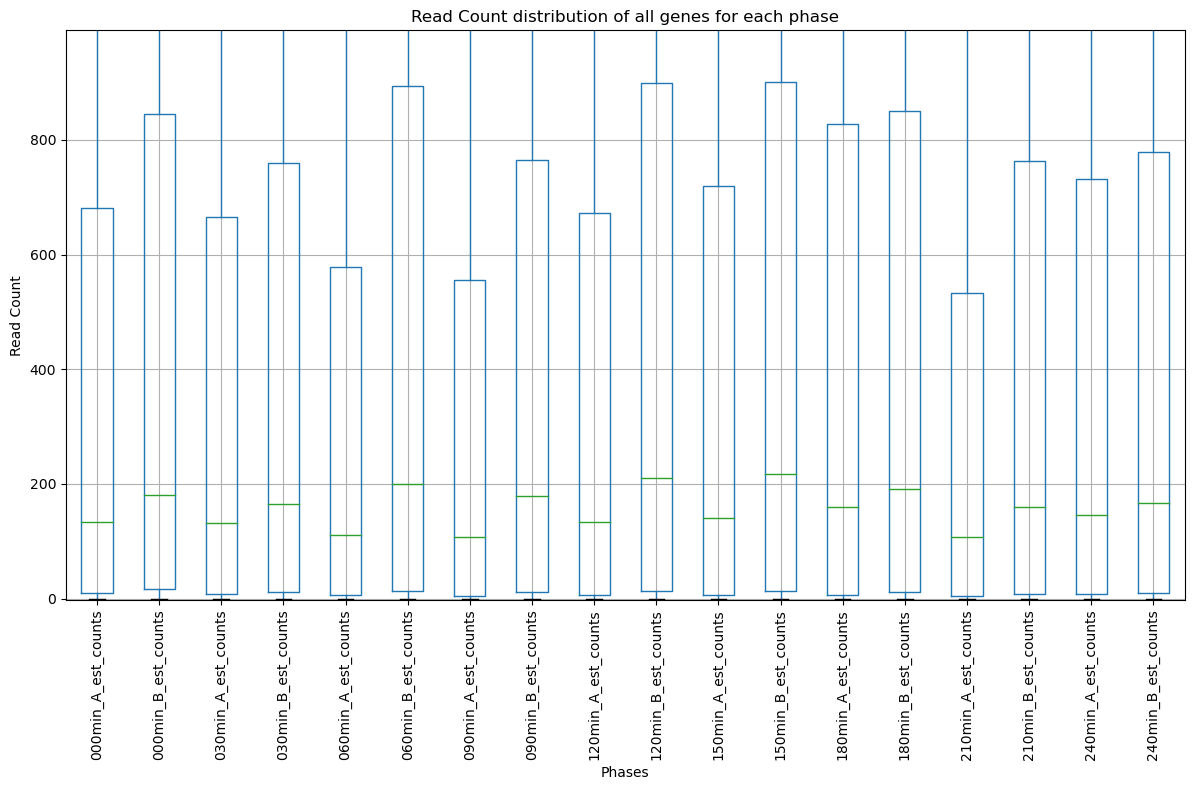

In [18]:
df_data = complete_data_df.loc[:, [col for col in complete_data_df if 'counts' in col]]

plt.figure(figsize=(12, 8))
df_data.boxplot(rot=90)
plt.title('Read Count distribution of all genes for each phase')
plt.xlabel('Phases')
plt.ylabel('Read Count')
plt.tight_layout()

max_third_quartile = np.max([np.quantile(df_data[col], 0.75) for col in list(df_data.columns)])

plt.ylim(top=max_third_quartile + max_third_quartile * 0.1)
plt.ylim(bottom=-2.5)
plt.show()

# Create a dataframe containing all TPM data at every timepoint (sorted by TTHERM_ID)

In [19]:
columns = sorted(list(dict_tpms.keys()))
columns

['000min_A',
 '000min_B',
 '030min_A',
 '030min_B',
 '060min_A',
 '060min_B',
 '090min_A',
 '090min_B',
 '120min_A',
 '120min_B',
 '150min_A',
 '150min_B',
 '180min_A',
 '180min_B',
 '210min_A',
 '210min_B',
 '240min_A',
 '240min_B']

In [20]:
curr_df = dict_tpms['000min_A'].sort_values(by='target_id')
dict_df_all_tpm = {'TTHERM_ID': curr_df['target_id'].values}
print(curr_df.head(3))

for col in columns:
    curr_df = dict_tpms[col].sort_values(by='target_id')
    print(curr_df.head(3))
    dict_df_all_tpm[col] = (curr_df)['tpm'].values

df_all_tpm = pd.DataFrame(dict_df_all_tpm)

print(df_all_tpm.shape)

df_all_tpm.head()

            target_id  length  eff_length  est_counts       tpm       rpk  \
9249  TTHERM_00000010    1587     1398.31       347.0  2.408500  0.248157   
9248  TTHERM_00000020    1665     1476.31        10.0  0.065742  0.006774   
9247  TTHERM_00000030    1887     1698.31        54.0  0.308601  0.031796   

      tpm_manual  cpm_manual  
9249    2.408490    6.188055  
9248    0.065742    0.178330  
9247    0.308600    0.962983  
            target_id  length  eff_length  est_counts       tpm       rpk  \
9249  TTHERM_00000010    1587     1398.31       347.0  2.408500  0.248157   
9248  TTHERM_00000020    1665     1476.31        10.0  0.065742  0.006774   
9247  TTHERM_00000030    1887     1698.31        54.0  0.308601  0.031796   

      tpm_manual  cpm_manual  
9249    2.408490    6.188055  
9248    0.065742    0.178330  
9247    0.308600    0.962983  
            target_id  length  eff_length  est_counts       tpm       rpk  \
9249  TTHERM_00000010    1587     1400.26       118.0  0.

,TTHERM_ID,000min_A,000min_B,030min_A,030min_B,060min_A,060min_B,090min_A,090min_B,120min_A,120min_B,150min_A,150min_B,180min_A,180min_B,210min_A,210min_B,240min_A,240min_B
0,TTHERM_00000010,2.408500,0.714664,2.957370,1.490380,0.556999,0.534218,0.189114,0.398338,0.231842,0.330559,0.317093,0.350251,0.456802,0.436540,0.368480,0.501366,0.483624,0.554840
1,TTHERM_00000020,0.065742,0.017211,0.105802,0.025901,0.065942,0.068509,0.093143,0.006184,0.127514,0.045545,0.112639,0.030162,0.031347,0.068903,0.091381,0.052747,0.251897,0.079436
2,TTHERM_00000030,0.308601,0.029927,0.021632,0.000000,0.000000,0.009159,0.024913,0.026873,0.012318,0.014850,0.019588,0.010490,0.010895,0.027217,0.028866,0.005727,0.024873,0.010622
3,TTHERM_00000031,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.046924,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,TTHERM_00000040,2.257010,2.549160,1.461130,1.611900,1.714520,1.882660,1.821900,2.025710,2.036640,2.232350,2.203750,2.413930,1.952220,2.414790,1.837740,1.938460,1.785950,2.175010


In [21]:
all_cols = list(df_all_tpm.columns)
all_cols

['TTHERM_ID',
 '000min_A',
 '000min_B',
 '030min_A',
 '030min_B',
 '060min_A',
 '060min_B',
 '090min_A',
 '090min_B',
 '120min_A',
 '120min_B',
 '150min_A',
 '150min_B',
 '180min_A',
 '180min_B',
 '210min_A',
 '210min_B',
 '240min_A',
 '240min_B']

In [22]:
tpm_cols = [col for col in df_all_tpm.columns[1:]]
tpm_cols

['000min_A',
 '000min_B',
 '030min_A',
 '030min_B',
 '060min_A',
 '060min_B',
 '090min_A',
 '090min_B',
 '120min_A',
 '120min_B',
 '150min_A',
 '150min_B',
 '180min_A',
 '180min_B',
 '210min_A',
 '210min_B',
 '240min_A',
 '240min_B']

# Create a dataframe containing all CPM data at every timepoint (sorted by TTHERM_ID)

In [23]:
columns = sorted(list(dict_tpms.keys()))
columns

['000min_A',
 '000min_B',
 '030min_A',
 '030min_B',
 '060min_A',
 '060min_B',
 '090min_A',
 '090min_B',
 '120min_A',
 '120min_B',
 '150min_A',
 '150min_B',
 '180min_A',
 '180min_B',
 '210min_A',
 '210min_B',
 '240min_A',
 '240min_B']

In [24]:
curr_df = dict_cpms['000min_A'].sort_values(by='target_id')
dict_df_all_cpm = {'TTHERM_ID': curr_df['target_id'].values}
print(curr_df.head(3))

for col in columns:
    curr_df = dict_cpms[col].sort_values(by='target_id')
    print(curr_df.head(3))
    dict_df_all_cpm[col] = (curr_df)['cpm_manual'].values

df_all_cpm = pd.DataFrame(dict_df_all_cpm)

print(df_all_cpm.shape)

df_all_cpm.head()

            target_id  length  eff_length  est_counts       tpm       rpk  \
9249  TTHERM_00000010    1587     1398.31       347.0  2.408500  0.248157   
9248  TTHERM_00000020    1665     1476.31        10.0  0.065742  0.006774   
9247  TTHERM_00000030    1887     1698.31        54.0  0.308601  0.031796   

      tpm_manual  cpm_manual  
9249    2.408490    6.188055  
9248    0.065742    0.178330  
9247    0.308600    0.962983  
            target_id  length  eff_length  est_counts       tpm       rpk  \
9249  TTHERM_00000010    1587     1398.31       347.0  2.408500  0.248157   
9248  TTHERM_00000020    1665     1476.31        10.0  0.065742  0.006774   
9247  TTHERM_00000030    1887     1698.31        54.0  0.308601  0.031796   

      tpm_manual  cpm_manual  
9249    2.408490    6.188055  
9248    0.065742    0.178330  
9247    0.308600    0.962983  
            target_id  length  eff_length  est_counts       tpm       rpk  \
9249  TTHERM_00000010    1587     1400.26       118.0  0.

,TTHERM_ID,000min_A,000min_B,030min_A,030min_B,060min_A,060min_B,090min_A,090min_B,120min_A,120min_B,150min_A,150min_B,180min_A,180min_B,210min_A,210min_B,240min_A,240min_B
0,TTHERM_00000010,6.188055,2.218046,7.873441,4.494121,1.514111,1.664427,0.521891,1.239052,0.625592,1.008829,0.812176,1.105647,1.167824,1.234043,0.943127,1.327621,1.301825,1.505942
1,TTHERM_00000020,0.178330,0.056391,0.297441,0.082461,0.189264,0.225391,0.271383,0.020312,0.363247,0.146739,0.304566,0.100513,0.084625,0.205674,0.247010,0.147513,0.716004,0.227642
2,TTHERM_00000030,0.962983,0.112782,0.069986,0.000000,0.000000,0.034676,0.083503,0.101562,0.040361,0.055027,0.060913,0.040205,0.033850,0.093488,0.089822,0.018439,0.081364,0.035022
3,TTHERM_00000031,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.018342,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,TTHERM_00000040,11.484459,15.657899,7.715972,9.627313,9.236078,11.633653,9.957680,12.492081,10.877235,13.481628,11.167417,15.076998,9.901115,13.537077,9.341452,10.196866,9.535872,11.697315


# Jaccard filtering: https://academic.oup.com/bioinformatics/article/29/17/2146/240530#SEC2.2

In [25]:
cols_a = [col for col in df_all_cpm if 'A' in col]
cols_a

['000min_A',
 '030min_A',
 '060min_A',
 '090min_A',
 '120min_A',
 '150min_A',
 '180min_A',
 '210min_A',
 '240min_A']

In [26]:
def jaccard_similarity(set1, set2):
    # intersection of two sets
    intersection = len(set1.intersection(set2))
    
    # union of two sets
    union = len(set1.union(set2))
     
    return intersection / union

In [27]:
np.percentile(df_all_cpm.loc[:, tpm_cols].to_numpy().flatten(), 10)

0.0

In [28]:
percentiles = np.arange(0, 30.1, 0.1)

tpm_cutoffs = []

jaccard_similarity_means = []

for _percentile in percentiles:

    tpm_cutoff = np.percentile(df_all_cpm.loc[:, tpm_cols].to_numpy().flatten(), _percentile)

    tpm_cutoffs.append(tpm_cutoff)

    jaccard_similarities = []

    for col_a in cols_a:
        col_b = col_a.replace('A', 'B')

        jaccard_similarities.append(jaccard_similarity(set(df_all_cpm.loc[df_all_cpm[col_a] > tpm_cutoff, 'TTHERM_ID'].values), 
                                                        set(df_all_cpm.loc[df_all_cpm[col_b] > tpm_cutoff, 'TTHERM_ID'].values)))

    jaccard_similarity_means.append(np.mean(jaccard_similarities))


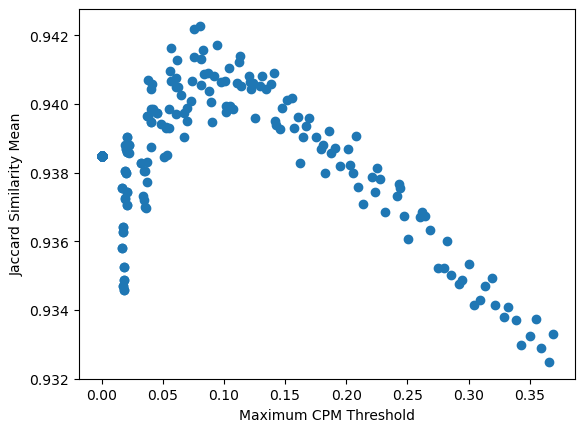

In [29]:
plt.scatter(x=tpm_cutoffs, y=jaccard_similarity_means)
plt.xlabel('Maximum CPM Threshold')
plt.ylabel('Jaccard Similarity Mean')
plt.show()

In [30]:
print(np.argmax(jaccard_similarity_means))
print(jaccard_similarity_means[np.argmax(jaccard_similarity_means)])
print(tpm_cutoffs[np.argmax(jaccard_similarity_means)])

208
0.9422724634302378
0.08041065599396688


In [31]:
CPM_THRESHOLD = tpm_cutoffs[np.argmax(jaccard_similarity_means)]

In [32]:
df_all_cpm['max_cpm'] = df_all_cpm[tpm_cols].apply(lambda x: max(x), axis=1)

In [33]:
df_all_cpm_filtered = df_all_cpm.loc[df_all_cpm['max_cpm'] > CPM_THRESHOLD]
df_all_cpm_filtered.shape, df_all_cpm.shape

((23112, 20), (26686, 20))

In [34]:
df_all_tpm.sample(10)

,TTHERM_ID,000min_A,000min_B,030min_A,030min_B,060min_A,060min_B,090min_A,090min_B,120min_A,120min_B,150min_A,150min_B,180min_A,180min_B,210min_A,210min_B,240min_A,240min_B
19768,TTHERM_00784420,9.093280,19.750200,10.231500,16.706300,10.245100,14.718600,9.428700,15.263100,9.913780,15.328500,10.241600,18.935100,10.592100,13.038600,10.268100,13.140900,10.389000,11.488600
10683,TTHERM_00418430,2.066080,2.621160,4.887750,4.876080,3.787360,5.911990,4.687960,5.505290,5.140860,6.038610,6.759320,5.922000,7.554690,7.925230,6.258250,8.270270,8.952820,7.187170
20687,TTHERM_00836730,0.062485,0.136068,0.044547,0.154076,0.015695,0.087986,0.017082,0.073676,0.067224,0.013498,0.035708,0.071540,0.000000,0.059739,0.019884,0.047378,0.054634,0.014538
25682,TTHERM_01308050,595.677000,326.129000,435.209000,321.436000,369.310000,287.766000,329.095000,281.292000,313.141000,272.689000,340.168000,234.411000,373.344000,316.225000,430.533000,382.413000,428.122000,383.441000
13057,TTHERM_00494735,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7163,TTHERM_00283825,0.219208,0.238549,0.034770,0.089994,0.073441,0.014714,0.059726,0.103460,0.176783,0.031546,0.124739,0.116951,0.105125,0.087402,0.139797,0.037021,0.079956,0.102044
12379,TTHERM_00473020,59.856300,68.138400,59.026600,72.162500,35.829400,60.651500,26.620300,52.027900,24.424000,50.312500,21.462700,48.969700,20.007900,40.716600,20.234200,34.881700,25.067400,34.222700
12887,TTHERM_00491079,0.012112,0.084462,0.011495,0.059661,0.036484,0.048660,0.000000,0.022826,0.026078,0.010475,0.027624,0.011097,0.000000,0.046260,0.000000,0.012207,0.031722,0.056333
16266,TTHERM_00628620,1.619110,5.607340,1.086890,4.135610,1.687190,4.865640,2.168250,6.153260,3.344140,5.498190,1.640430,5.824920,1.620840,4.206950,0.828881,2.264600,1.434580,1.817470
18195,TTHERM_00703331,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


## Check out genes with all zeros

In [35]:
rows_with_all_zeros = df_all_tpm[(df_all_tpm.iloc[:, 1:] == 0.0).all(axis=1)]

print(rows_with_all_zeros.shape)

rows_with_all_zeros.head()

(1160, 19)


,TTHERM_ID,000min_A,000min_B,030min_A,030min_B,060min_A,060min_B,090min_A,090min_B,120min_A,120min_B,150min_A,150min_B,180min_A,180min_B,210min_A,210min_B,240min_A,240min_B
41,TTHERM_00001455,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
112,TTHERM_00006300,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
119,TTHERM_00006354,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
173,TTHERM_00009840,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
236,TTHERM_00011510,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Check out rows with one nonzero

In [36]:
rows_with_one_nonzero = df_all_tpm[(df_all_tpm.iloc[:, 1:] == 0.0).sum(axis=1) == 17]

print(rows_with_one_nonzero.shape)

rows_with_one_nonzero.head()

(471, 19)


,TTHERM_ID,000min_A,000min_B,030min_A,030min_B,060min_A,060min_B,090min_A,090min_B,120min_A,120min_B,150min_A,150min_B,180min_A,180min_B,210min_A,210min_B,240min_A,240min_B
3,TTHERM_00000031,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.046924,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
135,TTHERM_00007490,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.050139,0.0
332,TTHERM_00013560,0.431226,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
442,TTHERM_00019600,0.000000,0.0,0.006266,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
584,TTHERM_00029970,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.032157,0.0,0.0,0.0,0.0,0.000000,0.0


## Check out the distribution of the number of zeros

In [37]:
num_zeros_counts = {}

for i in range(20):
    num_zeros = (df_all_tpm.iloc[:, 1:] == 0.0).sum(axis=1)
    
    rows_with_num_zeros = df_all_tpm[num_zeros == i]
    
    num_zeros_counts[i] = len(rows_with_num_zeros)

for num_zeros, count in num_zeros_counts.items():
    print(f"Number of rows with {num_zeros} zeros: {count}")

Number of rows with 0 zeros: 20956
Number of rows with 1 zeros: 584
Number of rows with 2 zeros: 349
Number of rows with 3 zeros: 345
Number of rows with 4 zeros: 234
Number of rows with 5 zeros: 236
Number of rows with 6 zeros: 228
Number of rows with 7 zeros: 211
Number of rows with 8 zeros: 186
Number of rows with 9 zeros: 183
Number of rows with 10 zeros: 195
Number of rows with 11 zeros: 177
Number of rows with 12 zeros: 196
Number of rows with 13 zeros: 204
Number of rows with 14 zeros: 204
Number of rows with 15 zeros: 262
Number of rows with 16 zeros: 305
Number of rows with 17 zeros: 471
Number of rows with 18 zeros: 1160
Number of rows with 19 zeros: 0


## Filter out genes with all zeros

In [38]:
df_no_all_zeros = df_all_tpm[~df_all_tpm.isin(rows_with_all_zeros)].dropna()
df_no_all_zeros.reset_index()
print(df_all_tpm.shape[0]-df_no_all_zeros.shape[0])
df_no_all_zeros.head()

1160


,TTHERM_ID,000min_A,000min_B,030min_A,030min_B,060min_A,060min_B,090min_A,090min_B,120min_A,120min_B,150min_A,150min_B,180min_A,180min_B,210min_A,210min_B,240min_A,240min_B
0,TTHERM_00000010,2.408500,0.714664,2.957370,1.490380,0.556999,0.534218,0.189114,0.398338,0.231842,0.330559,0.317093,0.350251,0.456802,0.436540,0.368480,0.501366,0.483624,0.554840
1,TTHERM_00000020,0.065742,0.017211,0.105802,0.025901,0.065942,0.068509,0.093143,0.006184,0.127514,0.045545,0.112639,0.030162,0.031347,0.068903,0.091381,0.052747,0.251897,0.079436
2,TTHERM_00000030,0.308601,0.029927,0.021632,0.000000,0.000000,0.009159,0.024913,0.026873,0.012318,0.014850,0.019588,0.010490,0.010895,0.027217,0.028866,0.005727,0.024873,0.010622
3,TTHERM_00000031,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.046924,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,TTHERM_00000040,2.257010,2.549160,1.461130,1.611900,1.714520,1.882660,1.821900,2.025710,2.036640,2.232350,2.203750,2.413930,1.952220,2.414790,1.837740,1.938460,1.785950,2.175010


In [39]:
df_all_zeros = df_all_tpm[df_all_tpm.isin(rows_with_all_zeros)].dropna()
df_all_zeros.reset_index()
print(df_all_tpm.shape[0]-df_all_zeros.shape[0])
df_all_zeros.head()

25526


,TTHERM_ID,000min_A,000min_B,030min_A,030min_B,060min_A,060min_B,090min_A,090min_B,120min_A,120min_B,150min_A,150min_B,180min_A,180min_B,210min_A,210min_B,240min_A,240min_B
41,TTHERM_00001455,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
112,TTHERM_00006300,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
119,TTHERM_00006354,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
173,TTHERM_00009840,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
236,TTHERM_00011510,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [40]:
df_no_all_zeros.shape

(25526, 19)

## Check out the genes which display the highest expression

In [41]:
[np.max(df_no_all_zeros[col]) for col in list(df_no_all_zeros.columns)[1:]]

[29123.3,
 41122.1,
 31265.3,
 46285.4,
 32316.9,
 44911.6,
 31502.3,
 40222.7,
 30837.1,
 41972.1,
 31539.9,
 46447.0,
 34335.0,
 32694.4,
 30844.6,
 31310.1,
 32997.9,
 31747.8]

In [42]:
max_tpm_ttherms = []

for col in df_no_all_zeros.columns[1:]:
    max_tpm = df_no_all_zeros[col].max()
    max_tpm_ttherm = df_no_all_zeros['TTHERM_ID'].loc[df_no_all_zeros[col] == df_no_all_zeros[col].max()].values[0]
    print(col, 'MAX:', max_tpm, '|', max_tpm_ttherm)
    max_tpm_ttherms.append(max_tpm_ttherm)
    

000min_A MAX: 29123.3 | TTHERM_01068180
000min_B MAX: 41122.1 | TTHERM_00526400
030min_A MAX: 31265.3 | TTHERM_01068180
030min_B MAX: 46285.4 | TTHERM_00760295
060min_A MAX: 32316.9 | TTHERM_01068180
060min_B MAX: 44911.6 | TTHERM_00760295
090min_A MAX: 31502.3 | TTHERM_01068180
090min_B MAX: 40222.7 | TTHERM_00526400
120min_A MAX: 30837.1 | TTHERM_01068180
120min_B MAX: 41972.1 | TTHERM_00526400
150min_A MAX: 31539.9 | TTHERM_01068180
150min_B MAX: 46447.0 | TTHERM_00526400
180min_A MAX: 34335.0 | TTHERM_01068180
180min_B MAX: 32694.4 | TTHERM_00526400
210min_A MAX: 30844.6 | TTHERM_01068180
210min_B MAX: 31310.1 | TTHERM_01068180
240min_A MAX: 32997.9 | TTHERM_01068180
240min_B MAX: 31747.8 | TTHERM_01068180


In [43]:
np.unique(max_tpm_ttherms)

array(['TTHERM_00526400', 'TTHERM_00760295', 'TTHERM_01068180'],
      dtype='<U15')

# FILTER OUT GENES IN THE TPM DATAFRAME

In [44]:
df_filtered = df_all_tpm.loc[df_all_tpm['TTHERM_ID'].isin(df_all_cpm_filtered['TTHERM_ID'].values)]

In [45]:
df_filtered.shape, df_no_all_zeros.shape, df_all_tpm.shape

((23112, 19), (25526, 19), (26686, 19))

In [46]:
df_filtered.loc[df_filtered['TTHERM_ID'].isin(df_all_zeros['TTHERM_ID'].values)]

,TTHERM_ID,000min_A,000min_B,030min_A,030min_B,060min_A,060min_B,090min_A,090min_B,120min_A,120min_B,150min_A,150min_B,180min_A,180min_B,210min_A,210min_B,240min_A,240min_B


In [47]:
df_filtered.head()

,TTHERM_ID,000min_A,000min_B,030min_A,030min_B,060min_A,060min_B,090min_A,090min_B,120min_A,120min_B,150min_A,150min_B,180min_A,180min_B,210min_A,210min_B,240min_A,240min_B
0,TTHERM_00000010,2.408500,0.714664,2.957370,1.490380,0.556999,0.534218,0.189114,0.398338,0.231842,0.330559,0.317093,0.350251,0.456802,0.436540,0.368480,0.501366,0.483624,0.554840
1,TTHERM_00000020,0.065742,0.017211,0.105802,0.025901,0.065942,0.068509,0.093143,0.006184,0.127514,0.045545,0.112639,0.030162,0.031347,0.068903,0.091381,0.052747,0.251897,0.079436
2,TTHERM_00000030,0.308601,0.029927,0.021632,0.000000,0.000000,0.009159,0.024913,0.026873,0.012318,0.014850,0.019588,0.010490,0.010895,0.027217,0.028866,0.005727,0.024873,0.010622
4,TTHERM_00000040,2.257010,2.549160,1.461130,1.611900,1.714520,1.882660,1.821900,2.025710,2.036640,2.232350,2.203750,2.413930,1.952220,2.414790,1.837740,1.938460,1.785950,2.175010
5,TTHERM_00000047,0.125703,0.062189,0.134722,0.144436,0.163839,0.187904,0.415551,0.492354,0.993735,0.693446,1.848730,0.707902,1.915730,1.076950,0.623573,1.039970,0.211403,0.626801


In [48]:
[np.max(df_filtered[col]) for col in tpm_cols]

[29123.3,
 41122.1,
 31265.3,
 46285.4,
 32316.9,
 44911.6,
 31502.3,
 40222.7,
 30837.1,
 41972.1,
 31539.9,
 46447.0,
 34335.0,
 32694.4,
 30844.6,
 31310.1,
 32997.9,
 31747.8]

# Filter out genes with all zeros

In [49]:
df_filtered_with_all_zeros = df_filtered[(df_filtered.iloc[:, 1:] == 0.0).all(axis=1)]

print(df_filtered_with_all_zeros.shape)

df_filtered_with_all_zeros.head()

(0, 19)


,TTHERM_ID,000min_A,000min_B,030min_A,030min_B,060min_A,060min_B,090min_A,090min_B,120min_A,120min_B,150min_A,150min_B,180min_A,180min_B,210min_A,210min_B,240min_A,240min_B


In [50]:
df_filtered_no_all_zeros = df_filtered[~df_filtered.isin(df_filtered_with_all_zeros)].dropna()
df_filtered_no_all_zeros.reset_index()
print(df_filtered.shape[0])
print(df_filtered_no_all_zeros.shape[0])
print(df_filtered.shape[0]-df_filtered_no_all_zeros.shape[0])
df_filtered_no_all_zeros.head()

23112
23112
0


,TTHERM_ID,000min_A,000min_B,030min_A,030min_B,060min_A,060min_B,090min_A,090min_B,120min_A,120min_B,150min_A,150min_B,180min_A,180min_B,210min_A,210min_B,240min_A,240min_B
0,TTHERM_00000010,2.408500,0.714664,2.957370,1.490380,0.556999,0.534218,0.189114,0.398338,0.231842,0.330559,0.317093,0.350251,0.456802,0.436540,0.368480,0.501366,0.483624,0.554840
1,TTHERM_00000020,0.065742,0.017211,0.105802,0.025901,0.065942,0.068509,0.093143,0.006184,0.127514,0.045545,0.112639,0.030162,0.031347,0.068903,0.091381,0.052747,0.251897,0.079436
2,TTHERM_00000030,0.308601,0.029927,0.021632,0.000000,0.000000,0.009159,0.024913,0.026873,0.012318,0.014850,0.019588,0.010490,0.010895,0.027217,0.028866,0.005727,0.024873,0.010622
4,TTHERM_00000040,2.257010,2.549160,1.461130,1.611900,1.714520,1.882660,1.821900,2.025710,2.036640,2.232350,2.203750,2.413930,1.952220,2.414790,1.837740,1.938460,1.785950,2.175010
5,TTHERM_00000047,0.125703,0.062189,0.134722,0.144436,0.163839,0.187904,0.415551,0.492354,0.993735,0.693446,1.848730,0.707902,1.915730,1.076950,0.623573,1.039970,0.211403,0.626801


In [51]:
df_filtered_no_all_zeros

,TTHERM_ID,000min_A,000min_B,030min_A,030min_B,060min_A,060min_B,090min_A,090min_B,120min_A,120min_B,150min_A,150min_B,180min_A,180min_B,210min_A,210min_B,240min_A,240min_B
0,TTHERM_00000010,2.408500,0.714664,2.957370,1.490380,0.556999,0.534218,0.189114,0.398338,0.231842,0.330559,0.317093,0.350251,0.456802,0.436540,0.368480,0.501366,0.483624,0.554840
1,TTHERM_00000020,0.065742,0.017211,0.105802,0.025901,0.065942,0.068509,0.093143,0.006184,0.127514,0.045545,0.112639,0.030162,0.031347,0.068903,0.091381,0.052747,0.251897,0.079436
2,TTHERM_00000030,0.308601,0.029927,0.021632,0.000000,0.000000,0.009159,0.024913,0.026873,0.012318,0.014850,0.019588,0.010490,0.010895,0.027217,0.028866,0.005727,0.024873,0.010622
4,TTHERM_00000040,2.257010,2.549160,1.461130,1.611900,1.714520,1.882660,1.821900,2.025710,2.036640,2.232350,2.203750,2.413930,1.952220,2.414790,1.837740,1.938460,1.785950,2.175010
5,TTHERM_00000047,0.125703,0.062189,0.134722,0.144436,0.163839,0.187904,0.415551,0.492354,0.993735,0.693446,1.848730,0.707902,1.915730,1.076950,0.623573,1.039970,0.211403,0.626801
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26679,TTHERM_02653503,0.987275,3.746770,1.423860,5.402760,1.895580,5.798440,2.144770,6.895340,2.525350,6.124430,1.542040,5.351530,0.959011,3.227840,0.498040,3.724690,2.295390,3.146150
26680,TTHERM_02653508,8.736360,15.887400,9.227230,14.731600,12.128600,16.979900,14.272500,17.341700,12.093600,18.363500,10.444800,17.967400,7.865660,13.160200,8.075010,10.029100,9.222800,10.063600
26682,TTHERM_02653516,1.055300,0.991837,0.598979,0.864190,0.302904,0.606287,0.238977,0.542659,0.221258,0.771146,0.312396,0.565463,0.236132,0.563077,0.435520,0.511777,0.574854,0.650485
26683,TTHERM_02653518,1.441810,1.248970,1.232530,1.410600,0.792453,0.994460,0.625057,0.940775,0.733694,0.765066,0.715717,0.773770,0.768118,0.826215,0.950177,1.082260,1.220590,1.172860


In [52]:
df_filtered_no_all_zeros[df_filtered_no_all_zeros.isna().any(axis=1)]

,TTHERM_ID,000min_A,000min_B,030min_A,030min_B,060min_A,060min_B,090min_A,090min_B,120min_A,120min_B,150min_A,150min_B,180min_A,180min_B,210min_A,210min_B,240min_A,240min_B


In [53]:
df_filtered_no_all_zeros.sample(10)

,TTHERM_ID,000min_A,000min_B,030min_A,030min_B,060min_A,060min_B,090min_A,090min_B,120min_A,120min_B,150min_A,150min_B,180min_A,180min_B,210min_A,210min_B,240min_A,240min_B
26106,TTHERM_01400720,9.645470,13.412500,8.093190,13.909600,5.332940,10.495900,5.643380,8.452040,4.923920,8.644800,4.430180,9.972700,4.304580,7.143700,5.494410,6.847910,6.107060,7.493690
23547,TTHERM_01052860,0.105682,0.315160,0.051152,0.101540,0.056838,0.158833,0.089893,0.133203,0.083385,0.147464,0.079589,0.274666,0.076051,0.139776,0.071426,0.059248,0.060496,0.093382
24251,TTHERM_01107435,0.274792,0.635867,0.100235,0.416457,0.031827,0.220649,0.161263,0.288676,0.113807,0.429754,0.108522,0.455292,0.141385,0.231967,0.093789,0.202111,0.230509,0.196581
23035,TTHERM_01014790,4.582700,3.000330,4.928600,3.976740,3.981950,4.410110,6.496930,5.894670,9.882700,6.715350,14.894500,7.796180,11.137000,9.328190,5.000430,8.105380,3.556970,5.675360
26249,TTHERM_01444890,0.024004,0.062848,0.011359,0.017732,0.018056,0.028856,0.000000,0.005644,0.019401,0.010395,0.006856,0.005507,0.011442,0.017150,0.000000,0.006015,0.005224,0.022309
155,TTHERM_00008700,0.021613,0.009436,0.010217,0.010643,0.014445,0.020188,0.011777,0.020314,0.019418,0.012487,0.020591,0.039697,0.017151,0.020570,0.009082,0.007206,0.006265,0.016733
7283,TTHERM_00287990,0.123824,0.148694,0.117012,0.127027,0.124110,0.132122,0.115267,0.152700,0.189157,0.203484,0.321560,0.286733,0.441940,0.368125,0.298930,0.373819,0.154724,0.304333
1120,TTHERM_00046950,14.700000,10.146700,26.792500,9.985460,16.971700,9.860390,14.578800,9.407310,13.586900,9.013260,15.324500,8.921890,14.963600,11.562500,13.089600,13.122100,11.309500,12.089600
6331,TTHERM_00245610,0.058193,0.014945,0.019416,0.010114,0.000000,0.005481,0.003731,0.006434,0.003691,0.008900,0.011741,0.000000,0.006519,0.003258,0.004315,0.003424,0.002977,0.006360
21704,TTHERM_00925710,0.005235,0.003048,0.004945,0.003437,0.005246,0.005583,0.007606,0.004917,0.009409,0.010589,0.019959,0.012826,0.006640,0.003319,0.021963,0.005227,0.009097,0.003241


# Export the filtered TPM data to CSV

In [54]:
df_filtered_no_all_zeros.to_csv('./kallisto.csv', index=False)